In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from astropy.io import fits
import scipy
from camb import model, initialpower

from astropy import units as u
import jax
import jax.numpy as jnp
from functools import partial
from jax.numpy.fft import rfft2, irfft2, rfftfreq, fftfreq

In [2]:
def fourier_coordinate(x, y, map_size):
    return (map_size // 2 + 1) * x + y

@partial(jax.jit, static_argnums=(4,))
def calculate_Cls(map, angle, ell_min, ell_max, n_bins):
    """
    map: the image from which the angular power spectra (Cls) has to be calculated
    angle: side angle in the units of degree
    ell_min: the minimum multipole moment to get the Cls
    ell_max: the maximum multipole moment to get the Cls
    n_bins: number of bins in the ells
    """
    ell_min = jnp.array(ell_min)
    ell_max = jnp.array(ell_max)
    # n_bins = jnp.array(n_bins, int)

    # Calculate the Fourier Transforms
    map_ft = rfft2(map)
    map_ft = map_ft.flatten()
    ell_edges = jnp.linspace(ell_min, ell_max, num=n_bins+1)

    # Define pixel physical size in Fourier space
    lpix = 360.0 / angle
    # Initialize arrays to store power and hits for each ell bin
    power_l = jnp.zeros(n_bins)
    hits = jnp.zeros(n_bins)
    
    def loop_body(j, val):
        i, power_l, hits = val
        lx = jnp.minimum(i, map.shape[1] - i) * lpix
        ly = j * lpix
        l = jnp.sqrt(lx**2. + ly**2.)
        pixid = fourier_coordinate(i, j, map.shape[1])
        bin_idx = jnp.digitize(l, ell_edges) - 1
        power_l = power_l.at[bin_idx].add(jnp.abs(map_ft[pixid]**2.))
        hits = hits.at[bin_idx].add(1)
        return i, power_l, hits

    def outer_loop_body(i, val):
        _, power_l, hits = val
        _, power_l, hits = jax.lax.fori_loop(0, map.shape[0], loop_body, (i, power_l, hits))
        return i, power_l, hits

    _, power_l, hits = jax.lax.fori_loop(0, map.shape[1], outer_loop_body, (0, power_l, hits))

    # Calculate Cls based on the accumulated power and hits
    normalization = (jnp.deg2rad(angle) / (map.shape[0] * map.shape[0]))**2
    cls_values = power_l / hits
    ell_bins = 0.5 * (ell_edges[1:] + ell_edges[:-1])

    return jnp.array(ell_edges), jnp.array(ell_bins), jnp.array(cls_values * normalization)




In [3]:
def load_data(file_no):
    base_path = "/feynman/work/dap/lcs/vt272285/HOWLS/HOWLS_DATA/"
    fiducial = "SLICS_LCDM/"
    fiducial_path = base_path + fiducial + "kappa_noise_GalCatalog_LOS_cone" + str(file_no) + ".fits_s333" + str(file_no) + "_zmin0.0_zmax3.0_sys_3.fits_ks_nomask_shear.fits"
    full_file_path = fiducial_path
    try:
        print("file found: path is: ", full_file_path)
        with fits.open(full_file_path) as hdu:
            data = hdu[0].data
            data = data[0]
            angle_ =10 * u.deg
        return data, angle_
    except FileNotFoundError:
        print(f"File {full_file_path} not found.")
        return None

# data, angle_ = load_data(file_no=76)

import sys
from skimage.transform import rescale, resize, downscale_local_mean
from astropy.convolution import convolve
from astropy.convolution import Tophat2DKernel

args = sys.argv
fname_in = args[1]
npix = 7745

fname1 = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS400'
# Read binary file into den_map
with open(fname1, 'rb') as f1:
    data_bin = np.fromfile(f1, dtype=np.float32)
    den_map = np.reshape(np.float32(data_bin), [npix, npix]) 
    
# Fix normalization
den_map *= 64.0
den_map = den_map[:-1,:-1]

kappa_downscaled = downscale_local_mean(den_map-np.mean(den_map), (5, 5))
data = kappa_downscaled
angle_ = 10*u.deg

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


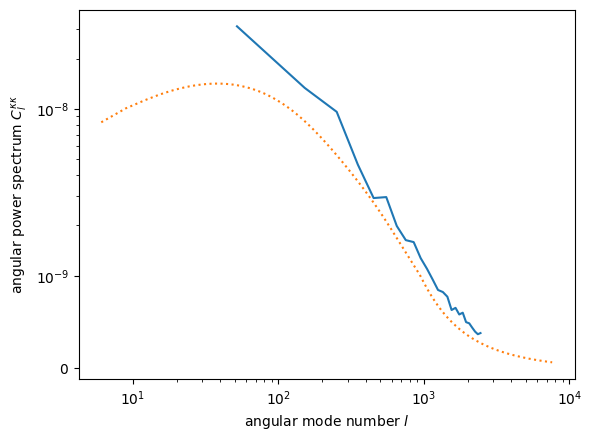

In [5]:
#######
##SLICS
########
h = 0.6898
Om = 0.2905
Ob = 0.0473
Oc = Om - Ob
Ol = 0.7095
mnu = 0
ns = 0.969
As_ = 2.1

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)
pars.InitPower.set_params(ns=ns, As=As_*1e-9)
pars.NonLinearModel.set_params(halofit_version='takahashi')
results = camb.get_results(pars)

zsource = 2.007
# Get the matter power spectra and lensing potential power spectra
chistar = results.comoving_radial_distance(zsource, tol=0.0000001) 
nz = 1000
chis = np.linspace(1e-5, chistar, nz)
zs = results.redshift_at_comoving_radial_distance(chis)


kmax=10000
dchis = (chis[2:]-chis[:-2])/2
chis = chis[1:-1]
zs = zs[1:-1]
win = ((chistar-chis)/(chis**2*chistar))**2

PK = camb.get_matter_power_interpolator(pars, nonlinear=True, 
    hubble_units=False, k_hunit=False, kmax=kmax,
    var1=model.Transfer_Weyl,var2=model.Transfer_Weyl, zmax=zsource)

# Do integral over chi
ls = np.arange(2, 2500+1, dtype=np.float64)
cl_kappa = np.zeros(ls.shape)
w = np.ones(chis.shape) 

for i, l in enumerate(ls):
    k = (l + 0.5) / chis
    w[:] = 1
    w[k < 1e-4] = 0
    w[k >= kmax] = 0
    cl_kappa[i] = np.dot(dchis, w * PK.P(zs, k, grid=False) * win / k**4)
    
cl_kappa *= (ls * (ls + 1))**2
cl_limber= 4*cl_kappa/2/np.pi

edges, ell, cl = calculate_Cls(jnp.array(data), angle_, 2, 2500, 25)


plt.plot(ell, cl)
plt.plot(ls/(h**3), cl_limber*(h**3), ls=":")
plt.xscale('symlog', linthresh=10, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.yscale('symlog', linthresh=1e-9, linscale=0.5, subs=[2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel(r'angular mode number $l$')
plt.ylabel(r'angular power spectrum $C_l^{\kappa\kappa}$')
plt.legend(frameon=False)
plt.show()

